In [4]:
import ximea_cam_aquire_save as xim
import imp
import run_analysis as ana
from ximea import xiapi


In [5]:
collection_mins = 1
save_batchsize = 1000

In [6]:
imp.reload(xim)
save_folder_list = ['./test', '/tb_disk/test']
xim.ximea_acquire(save_folder_list, max_collection_time=collection_mins, ims_per_file=save_batchsize)

SCENE_CAM Starting acquisition threads...
SCENE_CAM Opening Camera od
SCENE_CAM Opening Camera os
SCENE_CAM Aquiring Until Finished...
SCENE_CAM Recording Timestamp Syncronization Pre...
SCENE_CAM Recording Timestamp Syncronization Pre...
SCENE_CAM Reached 12000 frames collected. Exiting.
SCENE_CAM Camera os Cleanup...
SCENE_CAM Reached 12000 frames collected. Exiting.
SCENE_CAM Camera od Cleanup...
SCENE_CAM Camera od aquisition finished
SCENE_CAM Camera os aquisition finished
SCENE_CAM Finished Aquiring. Waiting for Save Queues to Empty...
All Done!


od missed frames total: 10.0 / 11000 = 0.09%
os missed frames total: 1.0 / 3700 = 0.03%


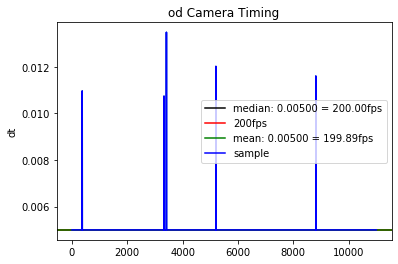

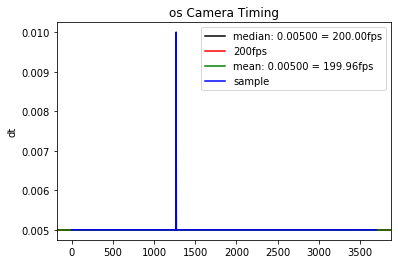

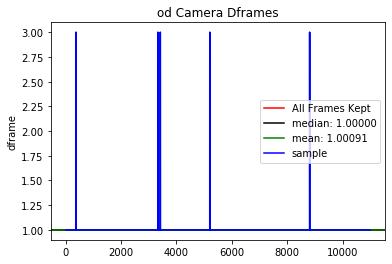

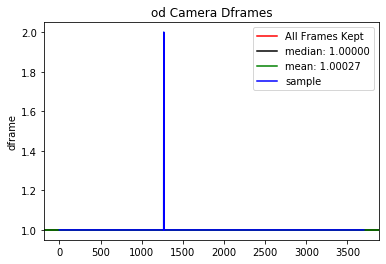

In [7]:
imp.reload(ana)
ana.count_missed_frames('./test/timestamps_od.tsv', 'od')
ana.count_missed_frames('./test/timestamps_os.tsv', 'os')
# ana.count_missed_frames('/tb_disk/test/timestamps_cy.tsv', 'cy')
ana.plot_camera_timing('./test/timestamps_od.tsv', './test/timestamp_plot_od.png', 'od')
ana.plot_camera_timing('./test/timestamps_os.tsv', './test/timestamp_plot_os.png', 'os')

ana.plot_camera_dframe('./test/timestamps_od.tsv', './test/dframe_plot_od.png', 'od')
ana.plot_camera_dframe('./test/timestamps_os.tsv', './test/dframe_plot_os.png', 'od')


In [5]:
cam_id = "XECAS1922000"

camera = xiapi.Camera()
camera.open_device_by_SN(cam_id)
xim.apply_cam_settings(camera, 'od.yaml')

params = ['limit_bandwidth_mode', 'limit_bandwidth', 'framerate', 'transport_data_target']
for p in params:
    print(p, camera.get_param(p))

camera.start_acquisition()    
image = xiapi.Image()
camera.get_image(image)
print(image.transport_frm)

camera.close_device()

limit_bandwidth_mode XI_OFF
limit_bandwidth 8000
framerate 200.0
transport_data_target XI_TRANSPORT_DATA_TARGET_CPU_RAM
17301515


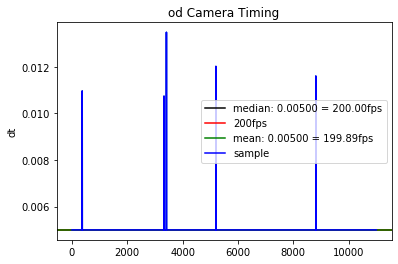

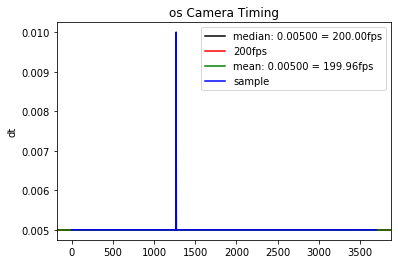

FileNotFoundError: [Errno 2] No such file or directory: '/tb_disk/test/timestamps_cy.tsv'

In [8]:
ana.plot_camera_timing('./test/timestamps_od.tsv', './test/timestamp_plot_od.png', 'od')
ana.plot_camera_timing('./test/timestamps_os.tsv', './test/timestamp_plot_os.png', 'os')
ana.plot_camera_timing('/tb_disk/test/timestamps_cy.tsv', './test/timestamp_plot_cy.png', 'cy')

ana.plot_camera_dframe('./test/timestamps_od.tsv', './test/dframe_plot_od.png', 'od')
ana.plot_camera_dframe('./test/timestamps_os.tsv', './test/dframe_plot_os.png', 'os')
ana.plot_camera_dframe('/tb_disk/test/timestamps_cy.tsv', './test/dframe_plot_cy.png', 'cy')


## Test HD write speed

In [9]:
import os
import time
import cProfile
import mmap

def ioTest():
    m = mmap.mmap(-1, 10*1024*1024)
    block = bytes('A'*10*1024*1024, 'utf-8')
    m.write(block) 
    filename = './test.bin'
    f = os.open(filename, os.O_WRONLY | os.O_CREAT | os.O_TRUNC |
                os.O_SYNC, os.O_DIRECT)
    start = time.time()
    for x in range(500):
        os.write(f,m)
    os.close(f)
    transferTime_sec = time.time() - start
    msg = 'Wrote {:0f}MB in {:0.03f}s.'
    print(msg.format(os.stat(filename).st_size/1024/1024,
                     transferTime_sec))
cProfile.run('ioTest()')

Wrote 5000.000000MB in 5.900s.
         546 function calls in 5.917 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.013    0.013    5.915    5.915 <ipython-input-9-ab262b9eaed7>:6(ioTest)
        1    0.002    0.002    5.917    5.917 <string>:1(<module>)
        3    0.000    0.000    0.000    0.000 iostream.py:195(schedule)
        2    0.000    0.000    0.000    0.000 iostream.py:307(_is_master_process)
        2    0.000    0.000    0.000    0.000 iostream.py:320(_schedule_flush)
        2    0.000    0.000    0.000    0.000 iostream.py:382(write)
        3    0.000    0.000    0.000    0.000 iostream.py:93(_event_pipe)
        3    0.000    0.000    0.000    0.000 socket.py:337(send)
        3    0.000    0.000    0.000    0.000 threading.py:1062(_wait_for_tstate_lock)
        3    0.000    0.000    0.000    0.000 threading.py:1104(is_alive)
        3    0.000    0.000    0.000    0.000 threading.py:506(i

In [ ]:
import cv2
def bin_to_im(binfile):
    a = []
    # # for uint16
    # with open(f, 'rb') as fn:
    #     bss = fn.read(2)
    #     while(bss):
    #         bss = fn.read(1)
    #         bbs = fn.read(1)
    #         bs = int.from_bytes(bss,'big')
    #         bb = int.from_bytes(bbs,'big')
    #         s = 256*bb+bs
    #         a.append(s)

    # for uint8
    with open(binfile, 'rb') as fn:
        bs = fn.read(1)
        while(bs):
            bs = fn.read(1)
            bs = int.from_bytes(bs,'big')
            a.append(bs)
    a = np.array(a)
    im = a.reshape((1544,2064))
    imc = cv2.cvtColor(np.uint16(im), cv2.COLOR_BayerGR2RGB)
    return(imc)

In [ ]:
imc_od = bin_to_im('test/od/frame_8000.bin')
imc_os = bin_to_im('test/os/frame_8000.bin')
plt.imshow(imc_od)
plt.title('OD')
plt.show()
plt.imshow(imc_os)
plt.title('OS')
plt.show()

# Capture for Ximea Cameras

https://www.ximea.com/support/wiki/apis/XiAPI_Manual

In [5]:
import ximea_cam_aquire_save as aquire
import imp
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2

## Bulk Collection

In [6]:
#settings:
num_frames = 10
cam_exposure = 1000
cam_gain = 20

In [8]:
imp.reload(aquire)
aquire.aquire_save_fullset(num_frames=num_frames, verbose=True, cam_exposure=cam_exposure, cam_gain=cam_gain)


AttributeError: module 'ximea_cam_aquire_save' has no attribute 'aquire_save_fullset'

In [4]:
ims = []
for i in range(num_frames):
    imb = []
    with open(f'capture/batch/data_raw_bytes_{i}.bin', 'rb') as f:
        byte = f.read(1)
        while(byte):
            byte = f.read(1)
            imb.append(int.from_bytes(byte,'big'))
        ims.append(np.array(imb).reshape((1544,2064)))
        #ims.append(np.array(imb).reshape((1544,2064)))
        #ims.append(np.array(map('|S1',list(imb))).reshape((1544,2064)))
        f.close()
for i in range(len(ims)):
    print(np.shape(np.uint8(ims[i])))
    #ims[i] = cv2.cvtColor(np.uint8(ims[i]), cv2.COLOR_BayerGR2RGB)
    ims[i] = np.uint8(ims[i])
    print(np.shape(ims[i]))
    imageio.imwrite(f'capture/batch/img_{i}.jpg', ims[i])

KeyboardInterrupt: 

In [ ]:
im = ims[0]
#im = cv2.cvtColor(np.uint8(im), cv2.COLOR_BayerGR2RGB)
plt.figure(figsize=(10,12))
plt.imshow(im)

In [ ]:
from datetime import datetime
from PIL import Image
#import time
 
def imgDate(fn):
    "returns the image date from image (if available)\nfrom Orthallelous"
    std_fmt = '%Y:%m:%d %H:%M:%S.%f'
    # for subsecond prec, see doi.org/10.3189/2013JoG12J126 , sect. 2.2, 2.3
    tags = [(36867, 37521),  # (DateTimeOriginal, SubsecTimeOriginal)
            (36868, 37522),  # (DateTimeDigitized, SubsecTimeOriginal)
            (306, 37520), ]  # (DateTime, SubsecTime)
    exif = Image.open(fn)._getexif()
 
    for t in tags:
        dat_stmp = exif.get(t[0])
        sub_stmp = exif.get(t[1], 0)
 
        # PIL.PILLOW_VERSION >= 3.0 returns a tuple
        dat_stmp = dat_stmp[0] if type(dat_stmp) == tuple else dat_stmp
        sub_stmp = sub_stmp[0] if type(sub_stmp) == tuple else sub_stmp
        if dat_stmp != None: break
 
    if dat_stmp == None: return None
    full = '{}.{}'.format(dat_stmp, sub_stmp)
    T = datetime.strptime(full, std_fmt)
    T = time.mktime(time.strptime(dT, '%Y:%m:%d %H:%M:%S')) + float('0.%s'%sub)
    return T

In [ ]:
Image.open('capture/batch/img_0.jpg')[36867]

In [ ]:
#line profile experiment running
imp.reload(runexp)
lp = LineProfiler()
# lp_wrapper = lp(runexp.run_experiment)
# lp_wrapper(subject_name=subject, 
#                       task_name=task, 
#                       exp_type=exp,
#                       save_dir=capture_dir,
#                       max_frames=frames)
lp_wrapper = lp(runexp.run_ximea_aquisition)
lp_wrapper('./capture/line_profile_test', 200, 1000)
lp.print_stats()

In [ ]:
imp.reload(runana)
runana.run_analysis(subject_name=subject, 
                      task_name=task, 
                      exp_type=exp,
                      read_dir=capture_dir,
                      save_dir=analysis_dir,
                      run_timestamp_stats=True,
                      run_convert_ims=True
                      )

In [ ]:
im = cv2.imread('./analysis/test_subject/test_task/exp/scene_camera/cam_od/frame_0.png')
plt.imshow(im)
plt.show()
plt.hist(im.flatten())

In [ ]:

f= 'capture/test_subject/test_task/exp/scene_camera/cam_od/frame_0.bin'
a = []
# # for uint16
# with open(f, 'rb') as fn:
#     bss = fn.read(2)
#     while(bss):
#         bss = fn.read(1)
#         bbs = fn.read(1)
#         bs = int.from_bytes(bss,'big')
#         bb = int.from_bytes(bbs,'big')
#         s = 256*bb+bs
#         a.append(s)

# for uint8
with open(f, 'rb') as fn:
    bs = fn.read(1)
    while(bs):
        bs = fn.read(1)
        bs = int.from_bytes(bs,'big')
        a.append(bs)

a = np.array(a)

In [ ]:
plt.hist(np.array(a).flatten(), bins=1000);

In [ ]:
im = a.reshape((1544,2064))
imc = cv2.cvtColor(np.uint16(im), cv2.COLOR_BayerGR2RGB)

In [ ]:
plt.imshow(im)
plt.show()
plt.imshow(imc)
plt.show()

In [ ]:
cv2.imwrite('test.png',imc.astype('float64'))
imcr = cv2.imread('test.png')
plt.imshow(imcr)
plt.show()
imcrw = cv2.balanceWhite(imcr)
plt.imshow(imcrw)
plt.show()


In [ ]:
plt.hist(np.array(imc).flatten(), bins=1000);

In [ ]:
plt.hist(np.array(imc.astype('float64')).flatten(), bins=1000);

In [ ]:
plt.hist(np.array(imcr).flatten(), bins=1000);